In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
%matplotlib inline
az.style.use("arviz-darkgrid")

from jax import numpy as jnp
from jax import lax
from jax.random import PRNGKey

import numpyro
from numpyro.infer import SVI, Predictive
from numpyro.optim import Adam
from numpyro.contrib.autoguide import AutoLaplaceApproximation, AutoContinuousELBO
import numpyro.diagnostics as diag
import numpyro.distributions as dist

from causalgraphicalmodels import CausalGraphicalModel as CGM

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as OLS

from itertools import combinations

In [ ]:
class quap():
    def __init__(model):
        self.guide = AutoLaplaceApproximation(model)
    
    def infer(rng=0, svi_len=1000, prior_len=20, post_len=(1000,), **kwargs):
        svi = SVI(model, guide, Adam(1), AutoContinuousELBO(), **kwargs)
        init_state = svi.init(PRNGKey(rng))
        state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(svi_len))
        param = svi.get_params(state)
        self.posterior = self.guide.sample_posterior(PRNGKey(rng), param, post_len)
        self.prior = Predictive(self.guide.model, num_samples=20)
        self.predictor = Predictive(self.guide.model, post)
        
    def precis(guide, param, prob=0.9):
        s = diag.summary(self.posterior, prob, False)
        return pd.DataFrame(s).T

In [207]:


l = np.array([('M','K'), ('M','N')])

for i in range(len(l)+1):
    for j in combinations(range(len(l)), i):
        l2 = l.copy()
        for elem in j:
            l2[elem] = np.flip(l2[elem])
        try:
            dag = CGM(nodes=['M','K','N'],edges=l2)
            print(l2)
            print(dag.get_all_independence_relationships())
        except AssertionError:
            pass

[['M' 'K']
 ['M' 'N']]
[('N', 'K', {'M'})]
[['K' 'M']
 ['M' 'N']]
[('N', 'K', {'M'})]
[['M' 'K']
 ['N' 'M']]
[('N', 'K', {'M'})]
[['K' 'M']
 ['N' 'M']]
[('N', 'K', set())]


In [208]:
import networkx as nx


In [ ]:
nx.draw_networkx_nodes()

# MultiVariate Regression 2

In [218]:
url = r"https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/milk.csv"
data = pd.read_csv(url, sep=';')
data.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [139]:
K = 'kcal.per.g'
M = 'mass'
LM = 'log_mass'
N = 'neocortex.perc'

In [140]:
data.dropna(subset=[K,M,N], inplace=True)

In [141]:
data[LM] = np.log(data[[M]])

In [142]:
scalers = dict()
for col in [K,LM,N]:
    data[col + "_origin"] = data[col]
    scalers[col] = StandardScaler(copy=False).fit(data[[col]])
    data[col] = scalers[col].transform(data[[col + "_origin"]])

# Do bigger brains produce better milk?

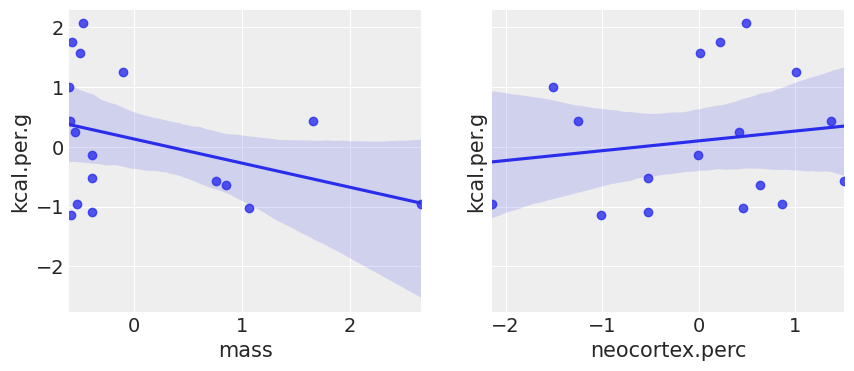

In [134]:
fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True)
sns.regplot(M, K, data=data, ax=ax[0]);
sns.regplot(N, K, data=data, ax=ax[1]);

## Simple regression
Let's Regress D on A
$$\begin{align}
K_i &∼ \text{Normal}( \mu_i , \sigma) \\
\mu_i &= a + b_NN_i \\
a &∼ \text{Normal}(0, 0.2)\\
b_N &∼ \text{Normal}(0, 0.5)\\
\sigma &∼ \text{Exponential}(1)
\end{align}$$

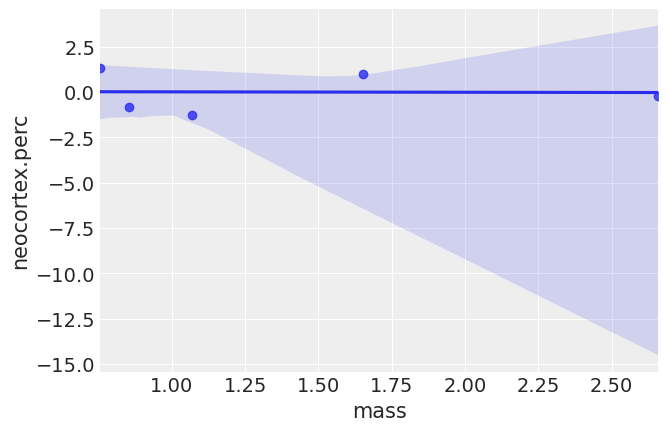

In [209]:
sns.regplot(M,N, data=data)

In [217]:
data

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,kcal.per.g_origin,mass_origin,neocortex.perc_origin,log_mass,log_mass_origin,K,clade_id
23,Ape,Pongo pygmaeus,-0.169476,37.78,7.37,54.85,0.852646,-0.814338,-0.641410,35.48,0.636245,-0.822183,-0.159411,-0.151584,0
24,Ape,Gorilla gorilla gorilla,-0.774748,27.18,16.29,56.53,2.658342,-0.245405,-0.956680,79.43,0.867663,1.633597,0.977703,-0.692956,0
26,Ape,Pan paniscus,-0.895802,21.18,11.68,67.14,1.068754,-1.247406,-1.019734,40.74,0.460092,-0.334306,0.066494,-0.801230,0
27,Ape,P troglodytes,-0.048422,36.84,9.54,53.62,0.755274,1.325529,-0.578357,33.11,1.506651,-1.084072,-0.280675,-0.043310,0
28,Ape,Homo sapiens,1.888448,50.49,9.84,39.67,1.652576,0.981621,0.430506,54.95,1.366764,0.606964,0.502335,1.689079,0


In [270]:
d = data
d["clade_id"] = d.clade.astype("category").cat.codes
d['clade'].cat.categories

Index(['Ape', 'New World Monkey', 'Old World Monkey', 'Strepsirrhine'], dtype='object')

In [272]:
import scipy.stats as st

In [432]:
v1 = st.norm().rvs(1000)
v2 = st.norm(v1 ).rvs()

outcome = st.norm(loc=v1+v2).rvs()

In [433]:
o1 = OLS()
o1.fit(v1.reshape(-1,1), outcome)
o1.coef_

array([2.09650078])

In [434]:
o2 = OLS()
o2.fit(v2.reshape(-1,1), outcome)
o2.coef_

array([1.5268527])

In [435]:
o3 = OLS()
o3.fit(np.vstack([v1,v2]).T, outcome)
o3.coef_

array([1.01504539, 1.0181144 ])

In [431]:
o1.predict(v1.reshape(-1,1)) - outcome

array([ 7.70351862e-01,  1.67660930e+00,  2.73471537e-01,  5.07865393e+00,
        7.82731212e-01, -6.51839384e+00,  1.06011108e+00, -1.56000881e+00,
        2.13396386e+00, -1.85530830e+00,  2.29721446e-01, -6.76721781e-01,
        1.00482340e+00,  4.87327677e+00, -7.61951276e-01,  4.90065287e-01,
        2.73264544e+00,  7.47199628e-01, -9.17889174e-01, -1.84832542e+00,
       -1.56069560e+00, -1.11053140e+00, -4.10321495e+00, -2.57910649e-01,
       -5.64578893e-01, -1.65238105e+00,  8.28755341e-01,  5.26621016e+00,
        9.34472641e-01,  2.68095796e+00,  1.92756889e+00, -4.85335506e+00,
        5.59567447e-01, -3.25828744e+00, -1.40401371e+00,  2.76577417e-01,
        2.85251794e+00, -3.08039213e+00, -2.10359409e-03,  6.03454250e-01,
        2.48359224e+00,  4.46602939e-01, -2.90844715e+00, -8.49751872e-01,
       -1.80181352e+00,  5.96569278e-01, -5.13662634e+00,  2.09211380e+00,
        4.48569324e-01,  1.17778655e-01,  2.42938598e+00, -8.51073042e-02,
       -3.87722193e-01, -